In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Dataset
import numpy as np
import netCDF4 as nc

# Plot
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Video
from IPython.display import Video

# Time
import time

In [2]:
Cp = 1003.5
Ep = 0.622
g = 9.8076
Rd = 287.05
Lv = 2.5e6

ndims = [512, 128]
iterations = 1200 + 1

In [3]:
def stream_function(u, rho, z):
    ubar = (u[1:,:] + u[:-1,:])/2
    rhobar = (rho[1:] + rho[:-1])/2
    delta_z = np.abs(np.diff(z))
    delta_psi = np.ma.dot(np.diag(delta_z*rhobar), ubar)
    psi = np.zeros_like(u)
    
    for i in range(psi.shape[0]):
        if i == 0:
            pass
        else:
            psi[i] = delta_psi[i-1] + psi[i-1]
    return psi

In [4]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]

In [5]:
class GIFs:
    def __init__(self, idx, name):
        self.fig = plt.figure(figsize=(16, 9), dpi = 160)
        self.ax1 = self.fig.add_axes([0.080,0.330,
                                      0.800,0.550])
        self.ax2 = self.fig.add_axes([0.080,0.080,
                                      0.800,0.250])
        self.case_idx = idx
        self.case_name = name
        return None
    def run(self):
        def init():
            # Simulation data
            self.RHO = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                                  dtype=float, 
                                  skiprows=237,
                                  usecols = 1,
                                  unpack=True,
                                  max_rows=46)[1:] 
            self.PBAR = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                                   dtype=float, 
                                   skiprows=237,
                                   usecols=3,
                                   unpack=True,
                                   max_rows=46)[1:]        
            dataset = nc.Dataset(filename_constructor(str(0).zfill(6), casenames[self.case_idx], varnames[-1]))
            self.x = dataset.variables["xc"][:]
            self.y = dataset.variables["yc"][:]
            self.z = dataset.variables["zc"][:]
            self.xx, self.pp = np.meshgrid(self.x, self.PBAR)
            
            
            
            # MSE and PSI
            theta = dataset.variables["th"][-1, :, :, :]
            qv = dataset.variables["qv"][-1, :, :, :]
            mse = Cp * theta + Lv * qv
            MSE = np.mean(mse, axis=1) / Cp
            image = self.ax1.contourf(self.xx, self.pp, MSE, levels = np.linspace(310,380,32), cmap=cm.bwr, extend='both', zorder=1)
            self.ax1.set_title(f"{str(casenames[self.case_idx])[1:]}", fontsize = 18)
                # x-axis
            self.ax1.set_xticks([], [])
                # y-axis
            self.ax1.set_ylim(self.PBAR[0], self.PBAR[-1])
            self.ax1.set_yticks(np.linspace(9e4,1e4,5, dtype = np.int64), 
                                ["900", "700", "500", "300", "100"],
                                fontsize = 18)
            self.ax1.set_ylabel("Pressure (hPa)", fontsize = 18)
            
            self.ax3 = self.fig.add_axes([0.910, 0.080, 
                                          0.025, 0.800])
            self.cbar = plt.colorbar(image, cax=self.ax3, 
                                     ticks = np.linspace(310,380,8, dtype = np.int64))
            self.cbar.ax.tick_params(labelsize = 18)
            image.remove()
            # SST
                # Initial SST
            dataset = nc.Dataset(filename_constructor(str(0).zfill(6), casenames[self.case_idx], varnames[1]))
            self.init_SST = np.mean(dataset.variables['tg'][-1, :, :], axis=0)
                # x-axis
            self.ax2.set_xlim(0,2**10*1e3)
            self.ax2.set_xticks(np.linspace(0,2**10*1e3,5, dtype = np.int64),
                                ["0", "256", "512", "768", "1024"],
                                fontsize = 18)
            self.ax2.set_xlabel("x (km)", fontsize = 18)
                # y-axis
            self.ax2.set_ylim(298,307)
            self.ax2.set_yticks(np.linspace(295,307,4, dtype = np.int64),
                                ["295", "299", "303", "307"],
                                fontsize = 18)
            self.ax2.set_ylabel("y (K)", fontsize = 18)
            return None
        def update(time):
            if (time%int(iterations/10) == 0):
                print(f"Completeness : {int(time/int(iterations/100))}%")
            try:
                self.plot1.remove()
                self.plot2.remove()
                self.plot3.remove()
                self.plot4.remove()
            except:
                pass
            dataset = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[self.case_idx], varnames[-1]))
            theta = dataset.variables["th"][-1, :, :, :]
            qv = dataset.variables["qv"][-1, :, :, :]
            
            dataset = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[self.case_idx], varnames[2]))
            u = dataset.variables['u'][-1, :, :, :]
            
            dataset = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[self.case_idx], varnames[1]))
            sst = dataset.variables['tg'][-1, :, :]

            mse = Cp * theta + Lv * qv
            MSE = np.mean(mse, axis=1) / Cp
            PHI = stream_function(np.mean(u, axis=1), self.RHO, self.z)
            SST = np.mean(sst, axis=0)
            
            self.plot1 = self.ax1.contour(self.xx, self.pp, PHI, levels = np.linspace(-2000,2000,7), colors='k', zorder=2)
            self.plot2 = self.ax1.contourf(self.xx, self.pp, MSE, levels = np.linspace(310,380,32), cmap=cm.bwr, extend='both', zorder=1)
            self.plot3, = self.ax2.plot(self.x, SST, "b-", zorder=1)
            self.plot4, = self.ax2.plot(self.x, self.init_SST, "k--", zorder = -1)
            self.fig.suptitle(f'Iterations : {time}', fontsize = 22)
            return None
        self.anim = animation.FuncAnimation(fig = self.fig, 
                                            func = update,
                                            frames = iterations,  
                                            interval = 50,
                                            init_func = init,
                                            blit = False)
        self.anim.save(f"HW2_{self.case_name}.mp4")
        return None

Completeness : 0%
Completeness : 1%
Completeness : 2%
Completeness : 3%
Completeness : 4%
Completeness : 5%
Completeness : 6%
Completeness : 7%
Completeness : 8%
Completeness : 9%
Completeness : 10%
Completeness : 0%
Completeness : 1%
Completeness : 2%
Completeness : 3%
Completeness : 4%
Completeness : 5%
Completeness : 6%
Completeness : 7%
Completeness : 8%
Completeness : 9%
Completeness : 10%
Completeness : 0%
Completeness : 1%
Completeness : 2%
Completeness : 3%
Completeness : 4%
Completeness : 5%
Completeness : 6%
Completeness : 7%
Completeness : 8%
Completeness : 9%
Completeness : 10%
Completeness : 0%
Completeness : 1%
Completeness : 2%
Completeness : 3%
Completeness : 4%
Completeness : 5%
Completeness : 6%
Completeness : 7%
Completeness : 8%
Completeness : 9%
Completeness : 10%


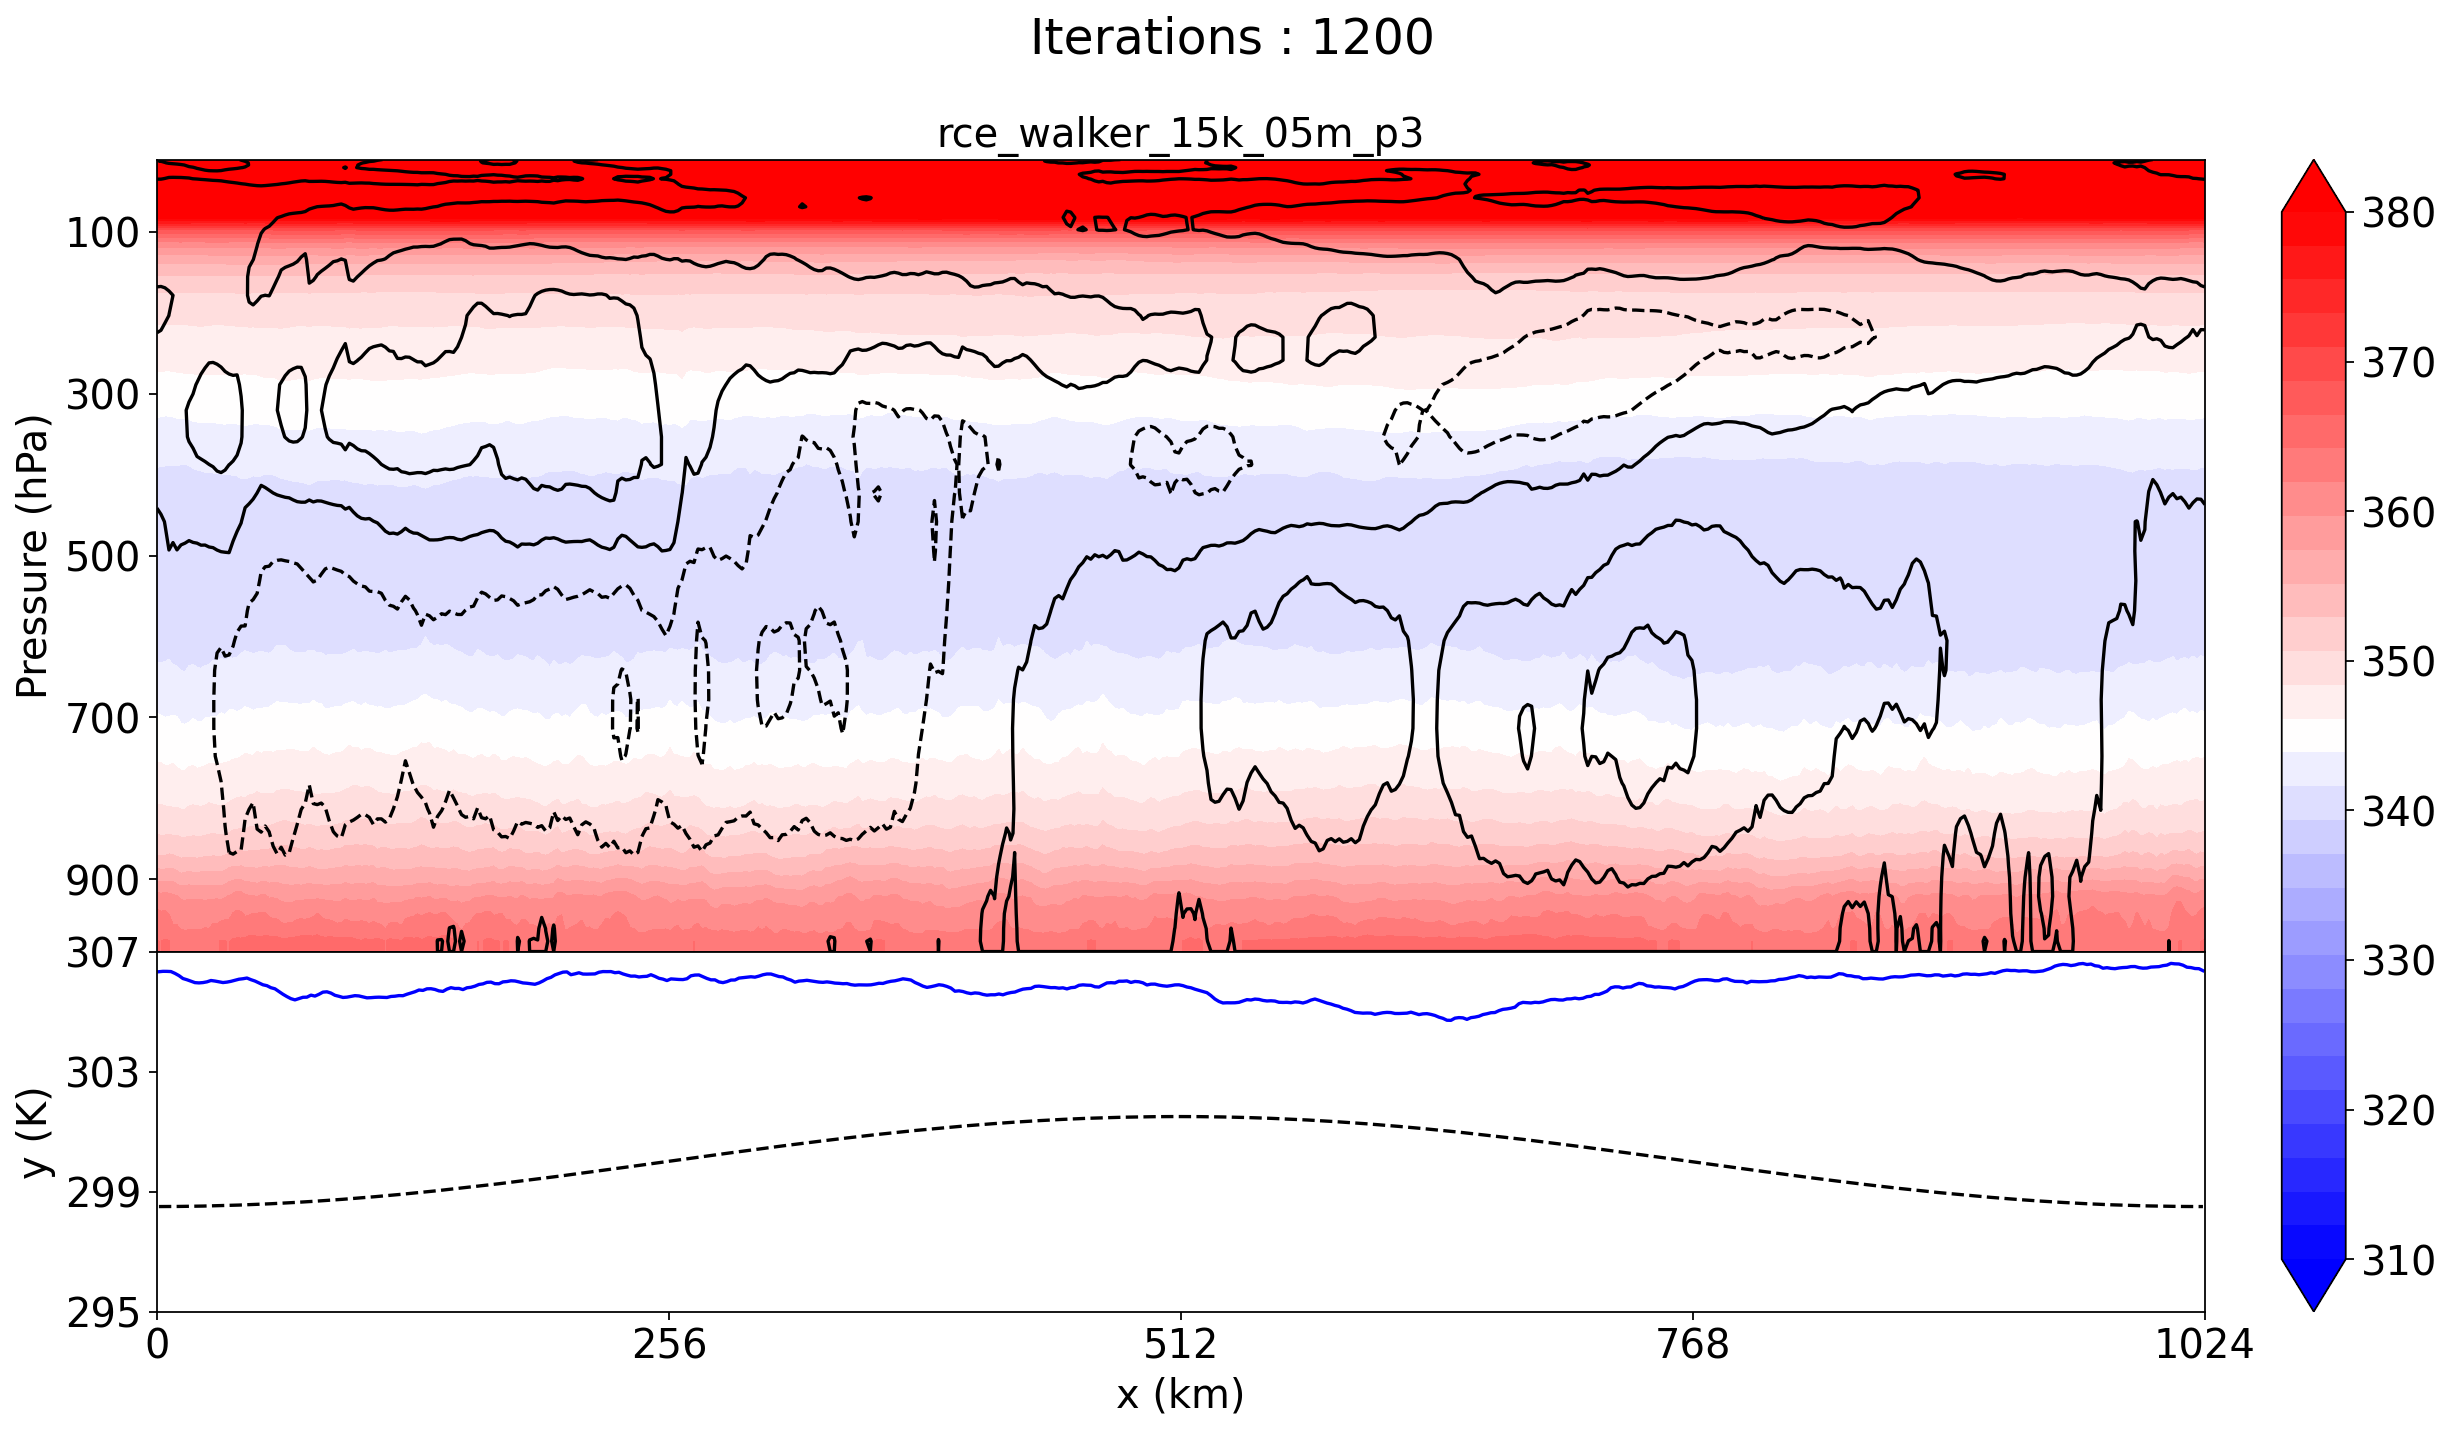

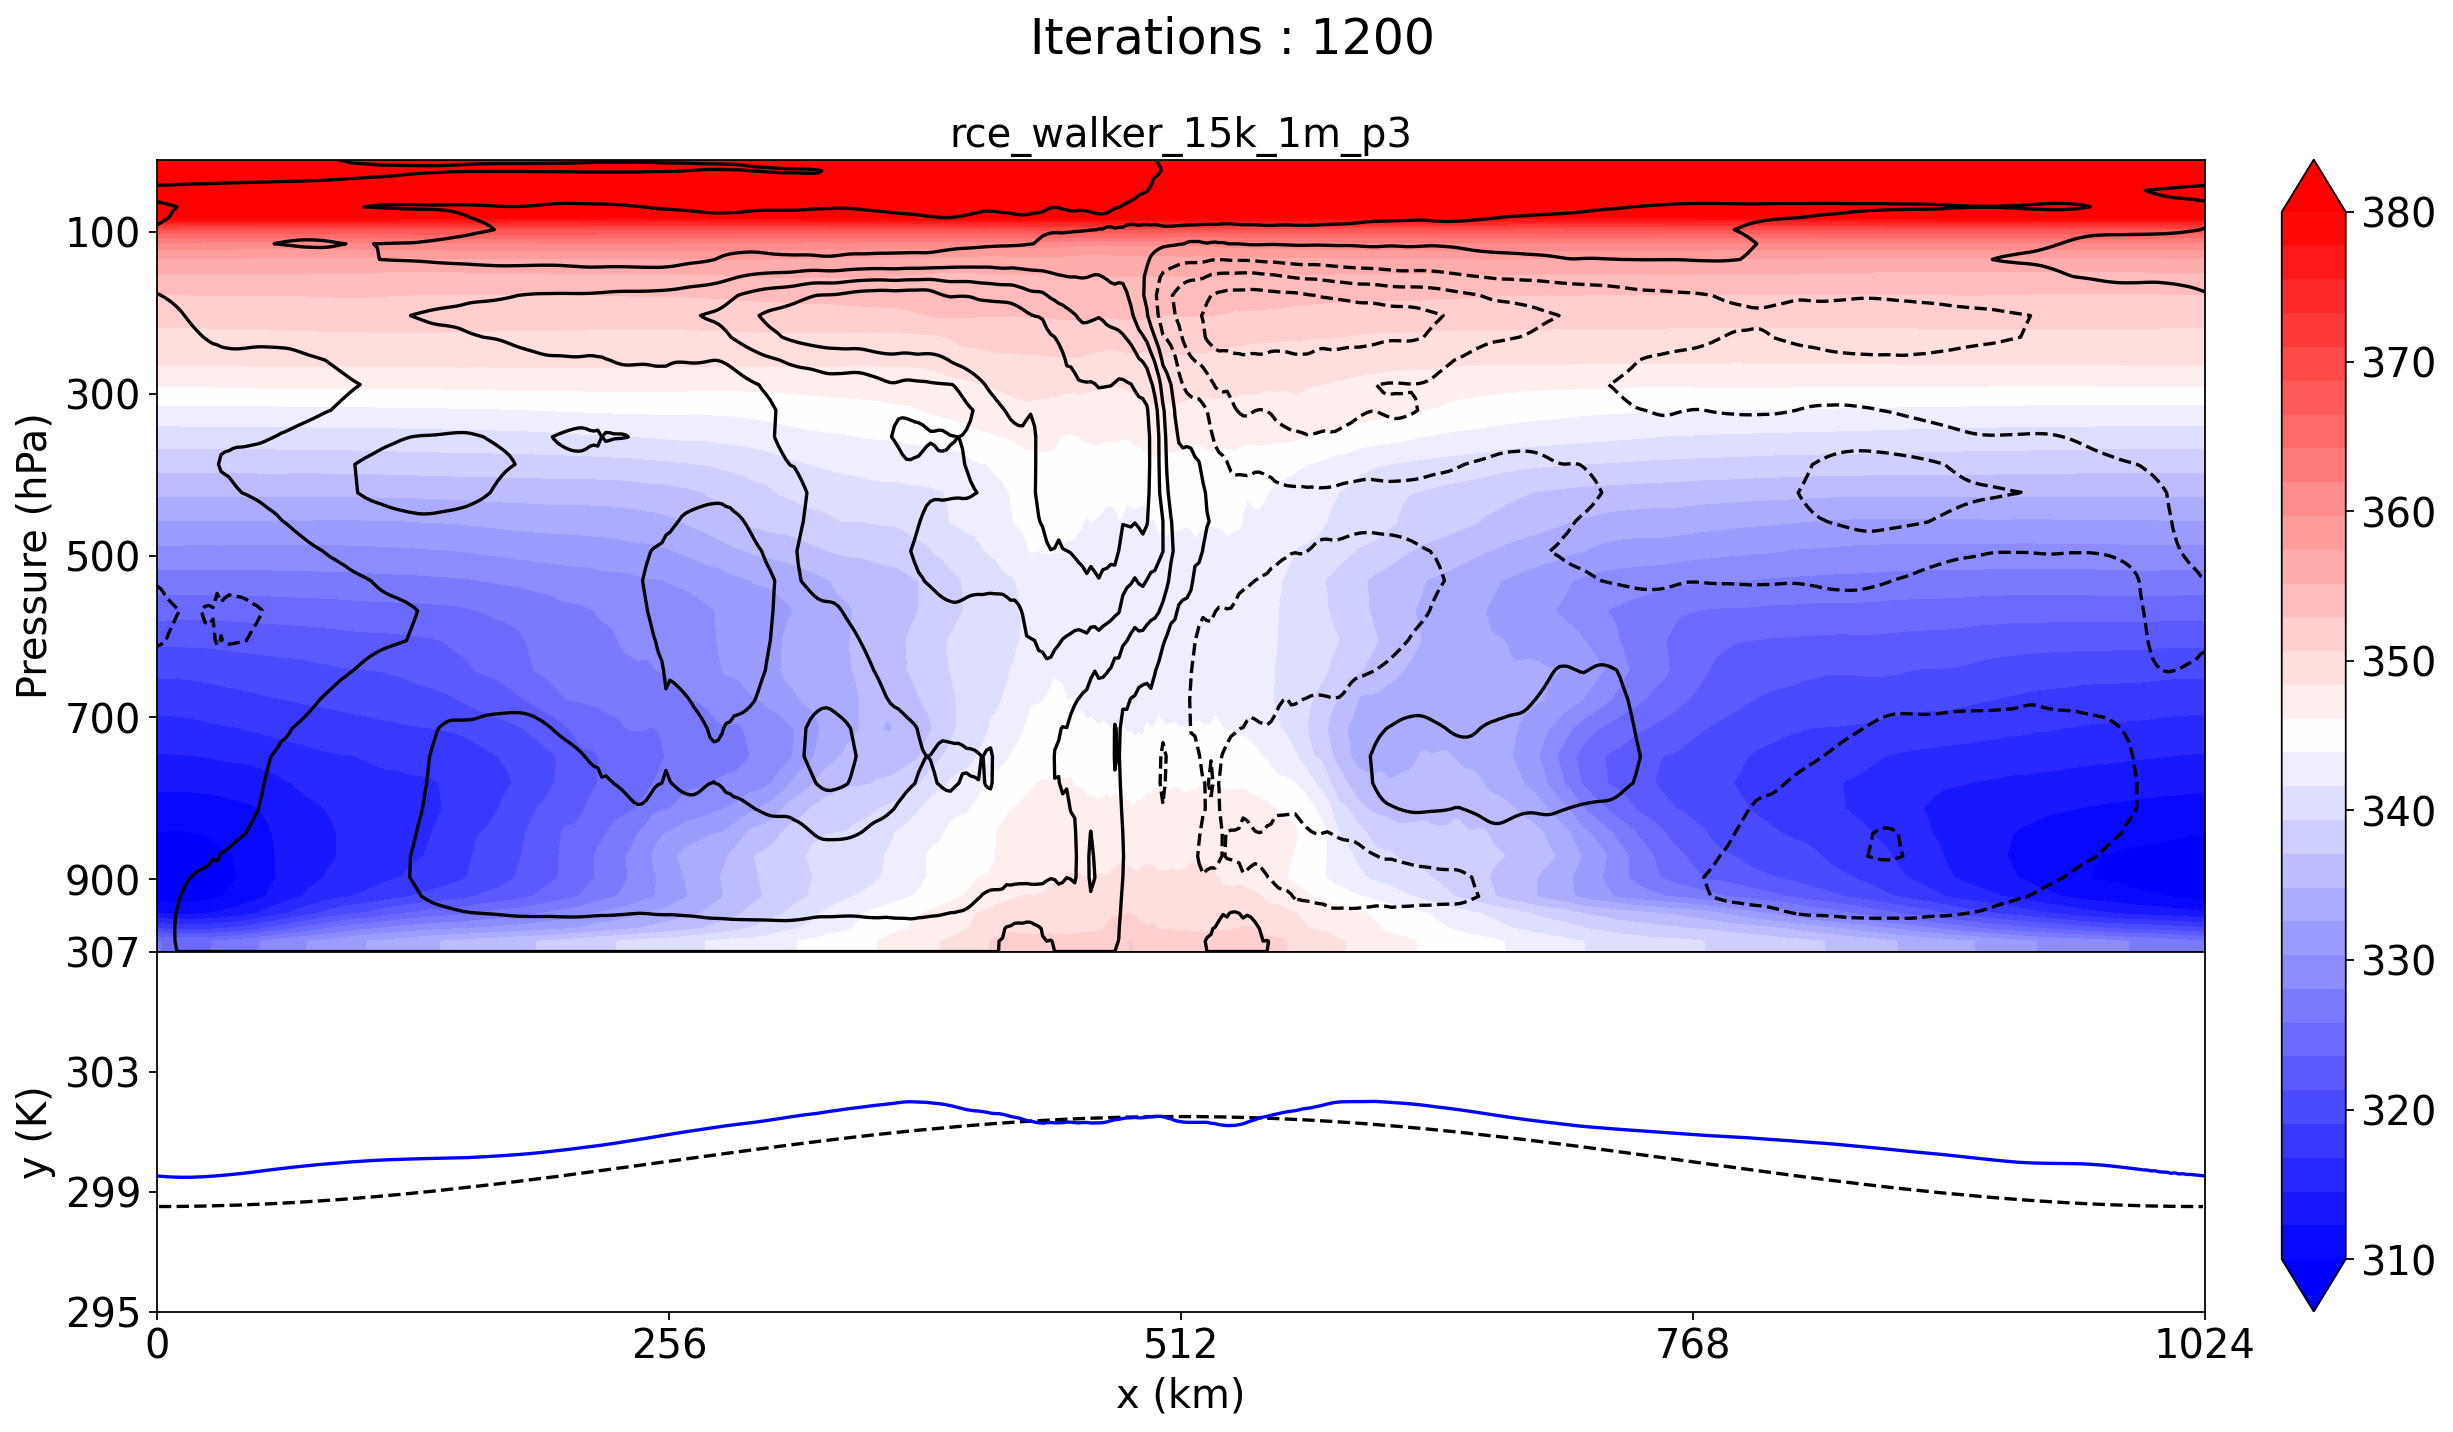

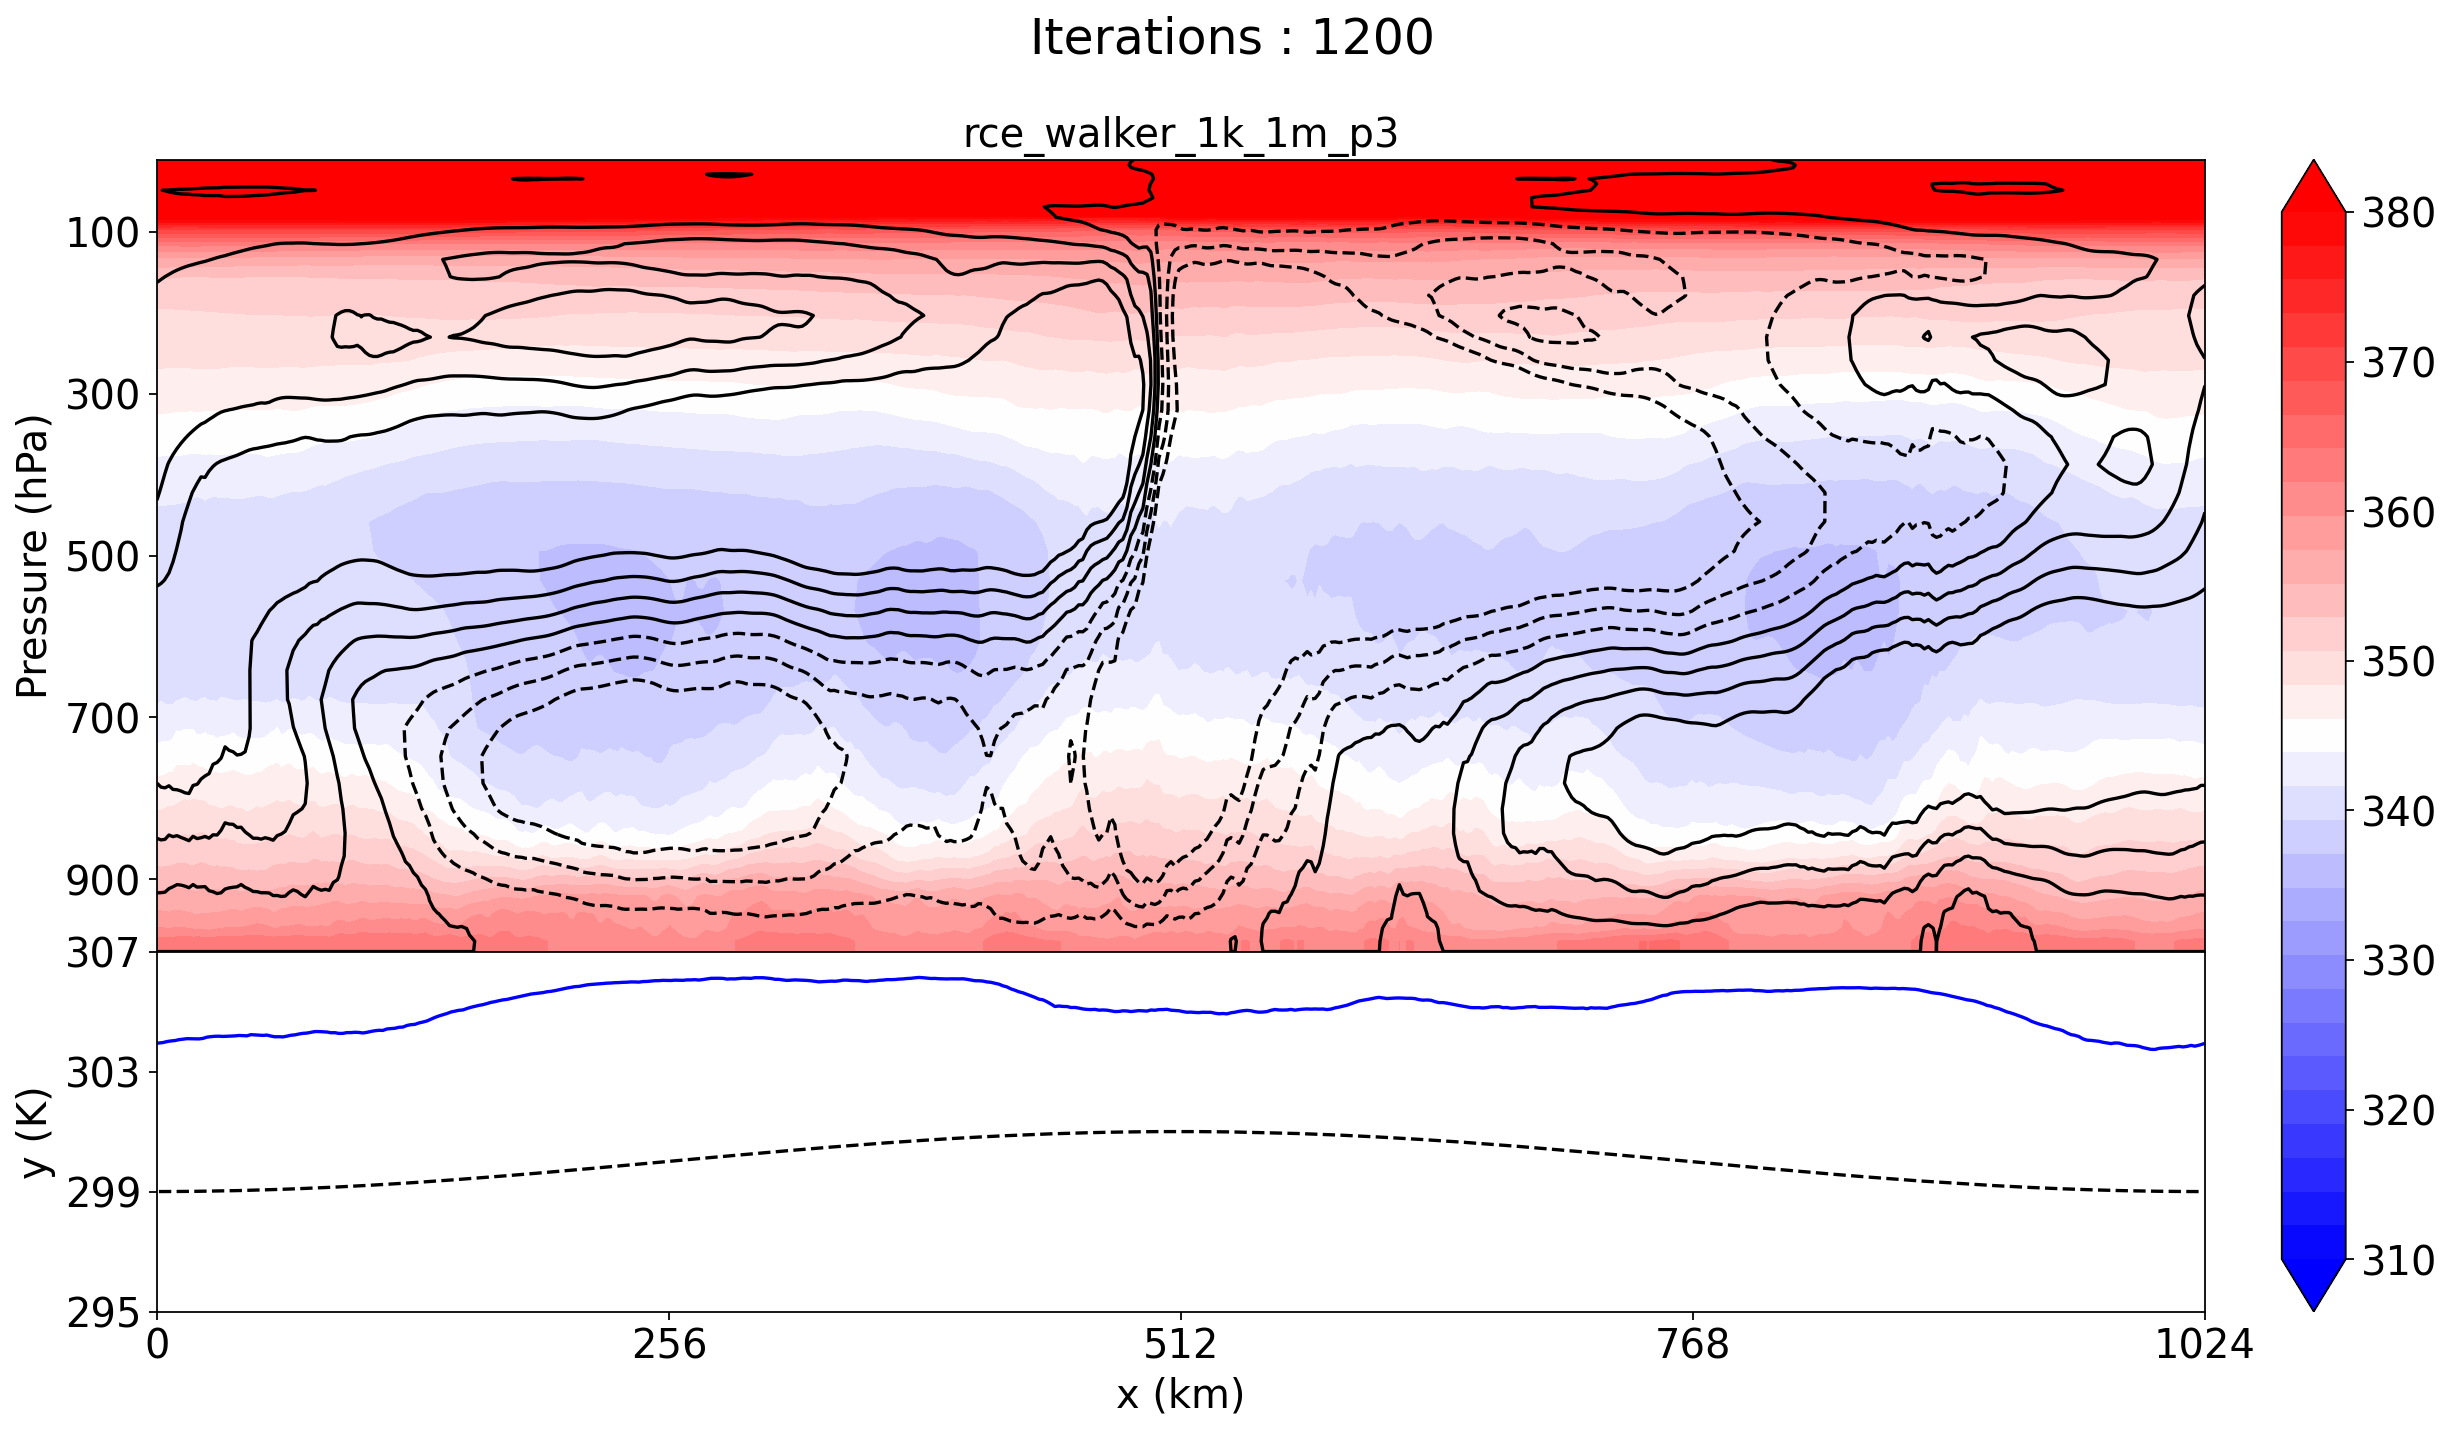

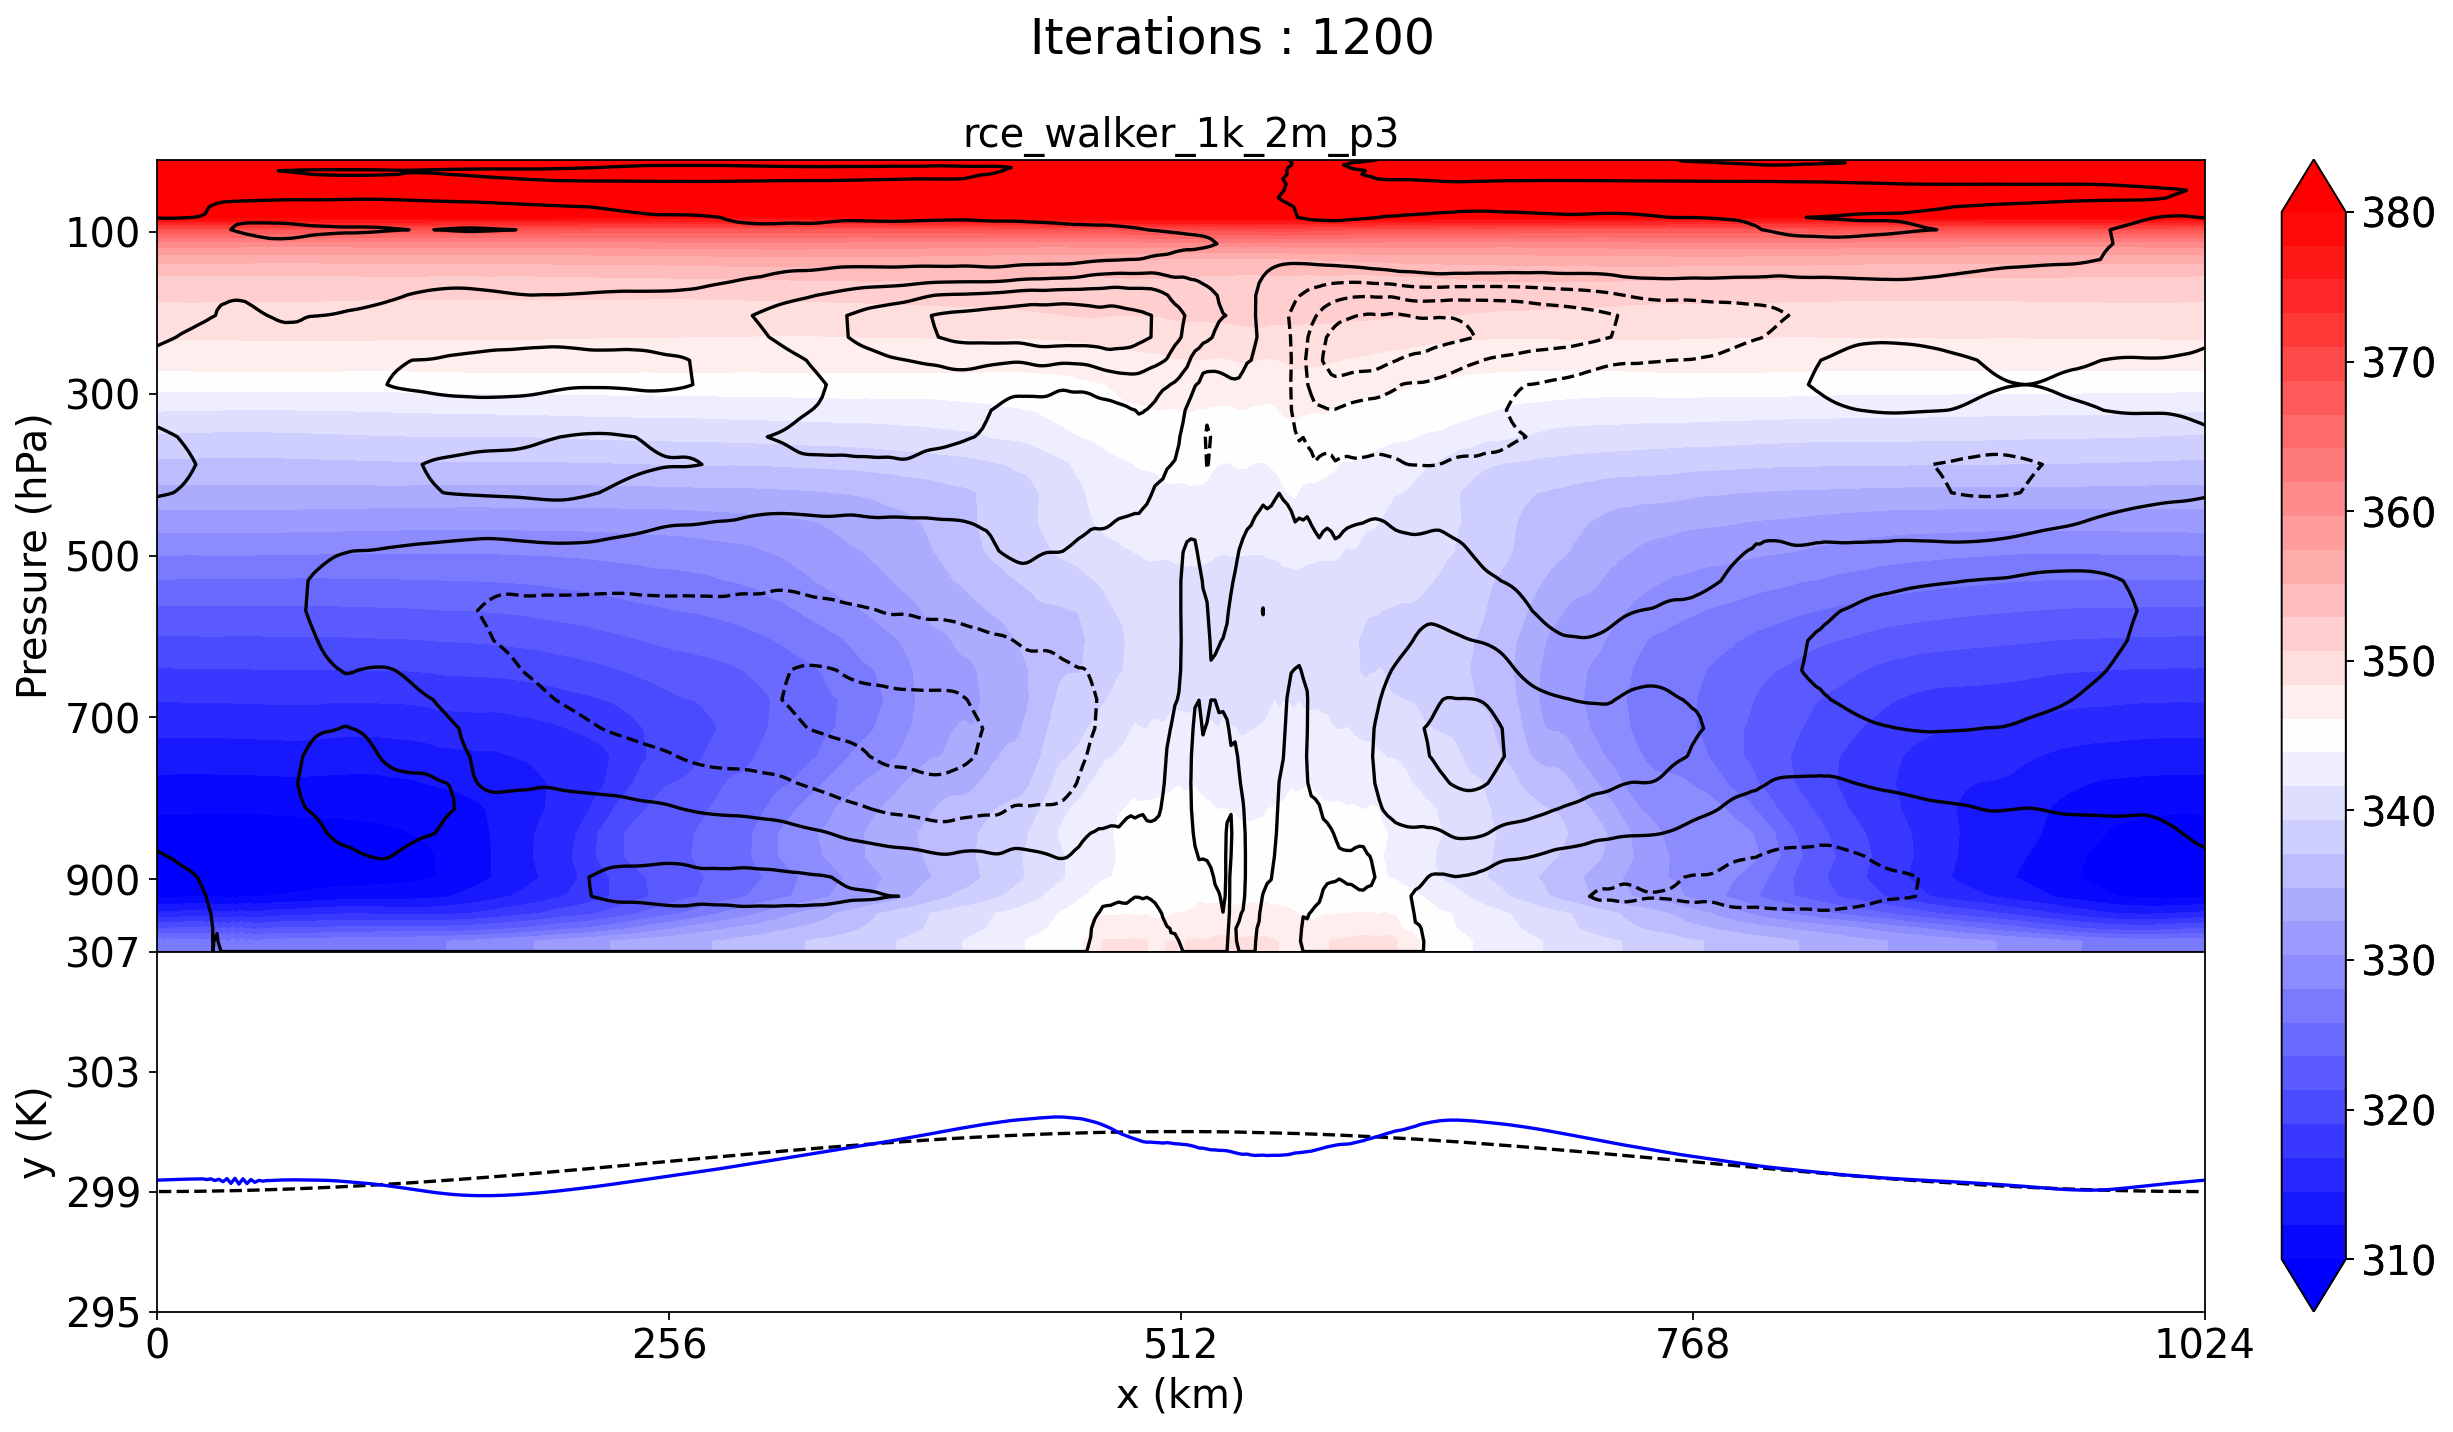

In [6]:
for i in range(4):
    test = GIFs(idx = i, name = casenames[i][1:])
    test.run()